In [14]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
from sklearn import datasets

In [4]:
import sys
from generate_data import make_data
from SWGG import SWGG_parallel
from utils import random_slice

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [122]:
get_rot= lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

def make_blobs_reg(n_samples, n_blobs, scale=.5):
    per_blob=int(n_samples/n_blobs)
    result = np.random.randn(per_blob,2) * scale + 5
    theta=(2*np.pi)/(n_blobs)
    for r in range(1,n_blobs):
        new_blob=(np.random.randn(per_blob,2) * scale + 5).dot(get_rot(theta*r))
        result = np.vstack((result,new_blob))
    return result

def make_data(expe,n_samples,dim=2):
    if expe=='mog_reg':
        r=.5
        xs = make_blobs_reg(n_samples=n_samples, n_blobs=3)
        xt = make_blobs_reg(n_samples=n_samples, n_blobs=3).dot(get_rot(r))
    elif expe=='gaussians' :
        mu_s = np.random.randint(-1,1,dim)
        cov_s = np.diag(np.random.randint(1,10,dim))
        cov_s = cov_s * np.eye(dim)

        mu_t = np.random.randint(-1,1,dim)
        cov_t = np.diag(np.random.randint(1,10,dim))
        cov_t = cov_t * np.eye(dim)
        
        xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
        
    X = torch.from_numpy(xs).to(device)
    Y = torch.from_numpy(xt).to(device)
    X=X.float()
    Y=Y.float()
    return X,Y
    
    

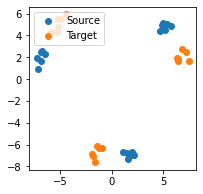

In [132]:
n=20
dim=15
X,Y=make_data('mog_reg',n,dim)

pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

# Exact $W^2_2$

In [125]:
ns=X.shape[0]
nt=Y.shape[0]
a, b = torch.ones((ns,))/nt, torch.ones((nt,))/nt
#The exact Wasserstein distance
C=ot.dist(X,Y)#,metric='euclidean')
print('W = ',ot.emd2(a,b,C))

W =  tensor(71.9089)


# $PDW$ with random Monte-Carlo projections

In [126]:
n_proj=20
theta=random_slice(n_proj,dim).T

W,_,_=SWGG_parallel(X,Y,theta)
print('PWD Monte Carlo = ',torch.mean(W))


PWD Monte Carlo =  tensor(119.5216)


In [127]:
theta.shape

torch.Size([15, 20])

# $PDW$ with Orthogonal projections

In [128]:
from scipy.stats import ortho_group

In [129]:
n_proj=3 #n_proj < dim
theta = ortho_group.rvs(dim)
theta = torch.tensor(theta[:,0:n_proj]).float()

W,_,_=SWGG_parallel(X,Y,theta)
print('PWD Orthogonal = ',torch.mean(W))

PWD Orthogonal =  tensor(115.8112)


# Evolution wrt $n$

In [137]:
n_seed=10

n_l=np.logspace(1, 3,20, dtype=int)
print('nb point',n_l)
dim=2

n_proj=2000
res=torch.empty((4,len(n_l),n_seed))

nb point [  10   12   16   20   26   33   42   54   69   88  112  143  183  233
  297  379  483  615  784 1000]


In [138]:
for j in range(n_seed):
    print(j,end=' ')
    for k,n in enumerate(n_l):
        X,Y=make_data('mog_reg',n,dim)
        ns=X.shape[0]
        nt=Y.shape[0]
        a, b = torch.ones((ns,))/nt, torch.ones((nt,))/nt
        
        #The exact Wasserstein distance
        C=ot.dist(X,Y)
        res[0,k,j]=ot.emd2(a,b,C,numItermax=1000000)
        
        #PWD Monte Carlo
        theta=random_slice(n_proj,dim).T
        res[1,k,j]=torch.mean(SWGG_parallel(X,Y,theta)[0])
        
        #SWGG Monte Carlo
        res[3,k,j]=torch.min(SWGG_parallel(X,Y,theta)[0])
        
        #PWD Orthogonal
        theta = ortho_group.rvs(dim)
        theta = torch.tensor(theta[:,0:min(n_proj,dim)]).float()
        res[2,k,j]=torch.mean(SWGG_parallel(X,Y,theta)[0])  

0 1 2 3 4 5 6 7 8 9 

In [139]:
res_mean=torch.mean(res,axis=2)
res_std=torch.std(res,axis=2)
label=['Exact Wasserstein','PWD Monte Carlo','PWD Orthogonal','SWGG']

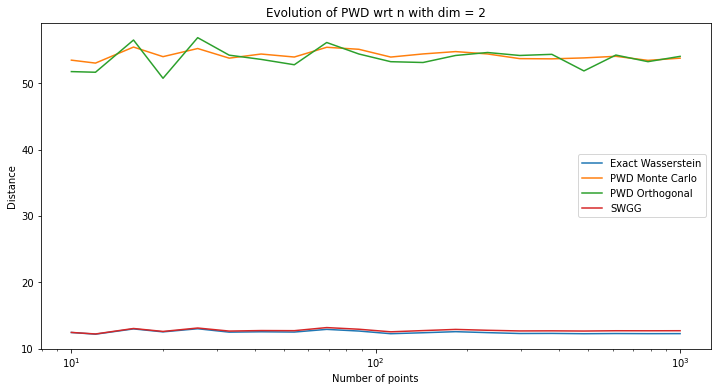

In [140]:
pl.figure(figsize=(12,6))
for i in range(len(label)):
    pl.plot(n_l, res_mean[i,:],c='C%i'%i,label=label[i])
    #pl.fill_between(n_l, res_mean[i,:] -  2*res_std[i,:], res_mean[i,:] + 2*res_std[i,:], alpha=0.2)

    
pl.xscale('log')
pl.xlabel("Number of points")
pl.ylabel("Distance")
pl.title('Evolution of PWD wrt n with dim = %i'%dim)
pl.legend()
pl.show()

# Evolution wrt $dim$

In [97]:
n_seed=10

dim_l=np.logspace(.4, 3,20, dtype=int)
print('dimension',dim_l)
n=500

n_proj=200
res=torch.empty((3,len(dim_l),n_seed))

dimension [   2    3    4    6    8   12   16   22   31   42   58   80  110  150
  206  283  388  532  729 1000]


In [98]:
for j in range(n_seed):
    print(j,end=' ')
    for k,d in enumerate(dim_l):
        X,Y=make_data('gaussians',n,d)
        ns=X.shape[0]
        nt=Y.shape[0]
        a, b = torch.ones((ns,))/nt, torch.ones((nt,))/nt
        
        #The exact Wasserstein distance
        C=ot.dist(X,Y)
        res[0,k,j]=ot.emd2(a,b,C,numItermax=1000000)
        
        #PWD Monte Carlo
        theta=random_slice(n_proj,d).T
        res[1,k,j]=torch.mean(SWGG_parallel(X,Y,theta)[0])
        
        #PWD Orthogonal
        theta = ortho_group.rvs(d)
        theta = torch.tensor(theta[:,0:min(n_proj,dim)]).float()
        res[2,k,j]=torch.mean(SWGG_parallel(X,Y,theta)[0])  

0 1 2 3 4 5 6 7 8 9 

In [99]:
res_mean=torch.mean(res,axis=2)
res_std=torch.std(res,axis=2)
label=['Exact Wasserstein','PWD Monte Carlo','PWD Orthogonal']

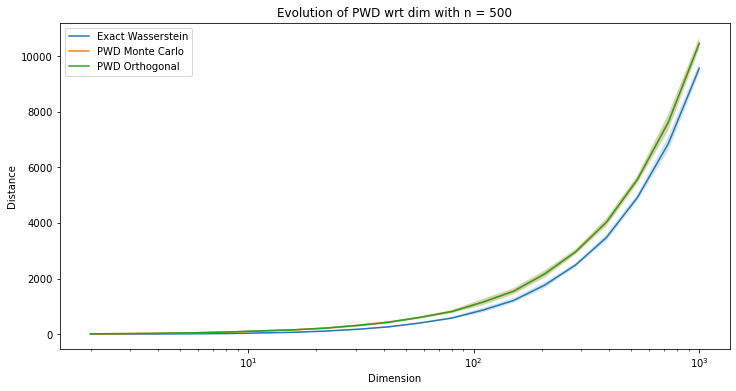

In [100]:
pl.figure(figsize=(12,6))
for i in range(3):
    pl.plot(dim_l, res_mean[i,:],c='C%i'%i,label=label[i])
    pl.fill_between(dim_l, res_mean[i,:] -  2*res_std[i,:], res_mean[i,:] + 2*res_std[i,:], alpha=0.2)

    
pl.xscale('log')
pl.xlabel("Dimension")
pl.ylabel("Distance")
pl.title('Evolution of PWD wrt dim with n = %i'%n)
pl.legend()
pl.show()